Packages

In [1]:
from os import listdir
import matplotlib.pyplot as plt
from imutils import paths
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model


import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

Data preparation

In [2]:
# Look at data folder structure
classes_dir = listdir("data/Kather_texture_2016_image_tiles_5000")
classes_dir

['.DS_Store',
 '01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [3]:
# Load data.
print("[INFO] loading images...")
imagePaths = list(paths.list_images("data/Kather_texture_2016_image_tiles_5000"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = (imagePath.split(os.path.sep)[-2][1])
    # Since we are going to use MobileNetV2 we need to resize the images
    # to the expected size by the pre-trained network.
    image = load_img(imagePath, target_size=(32, 32)) # Resize image #image = load_img(imagePath, target_size=(28, 28)) # Resize image
    image = img_to_array(image)
    image = preprocess_input(image)
    image = tf.cast(image, tf.float32) / 255.0 #normalize
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


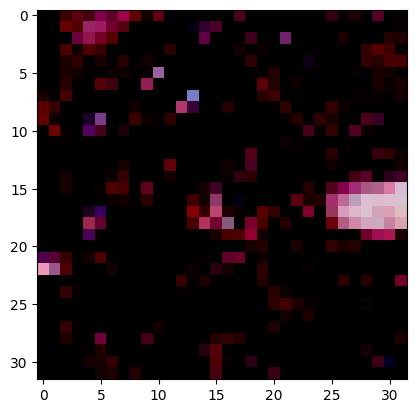

In [4]:
# display resized image
plt.imshow(data[0]*255)
#plt.imshow(data[0])

In [5]:
data.shape

(5000, 32, 32, 3)

In [6]:
# # perform one-hot encoding on the labels
# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)
# # labels = to_categorical(labels)
# print(labels[0], labels[0][0], type(labels[0]))

In [7]:
# input image dimensions
img_rows, img_cols = 32, 32

In [8]:
# Split into train, val, test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8)

In [9]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [10]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (32, 32, 3)


In [11]:
# Specify hyper-parameters-
# Images / epochs = batch size
batch_size = 240 # 100
num_classes = 8
num_epochs = 60 #60

In [12]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (4000, 32, 32, 3) & X_test.shape: (1000, 32, 32, 3)


In [13]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(4000).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(1000).batch(batch_size = batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


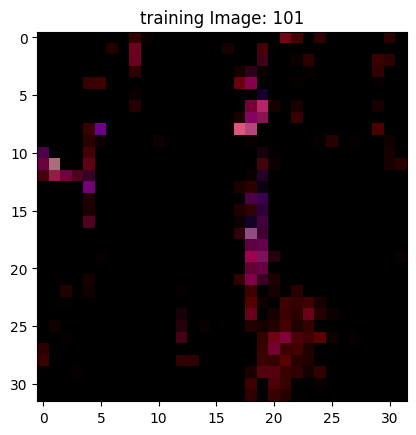

In [14]:
# Visualize one image
img_idx = 100

plt.imshow(X_train[img_idx]*255)
plt.title(f"training Image: {img_idx + 1}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

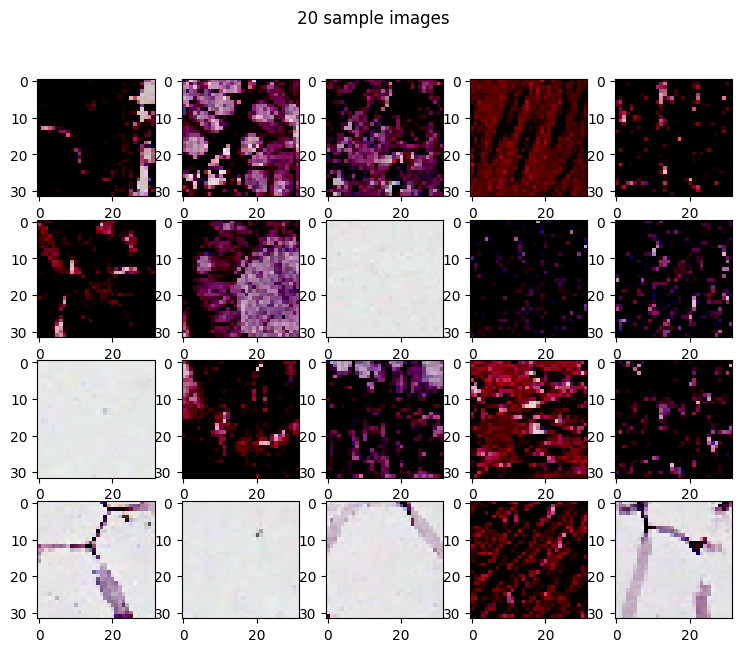

In [15]:
# Visualize 20 images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i]*255, cmap = plt.get_cmap('gray'))

plt.suptitle("20 sample images")
plt.show()

VAE encoder network

In [16]:
class ConvBlock(Model):
    def __init__(
        self, num_filters,
        kernel_size, stride_length,
        pooling_size, pooling_stride,
        padding_type = 'same'
    ):
        super(ConvBlock, self).__init__()

        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False,
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.pool = MaxPooling2D(
            pool_size = pooling_size,
            strides = pooling_stride
        )


    def call(self, x):
        x = tf.keras.activations.relu(self.bn(self.conv1(x)))
        x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        return x

In [17]:
class Conv6_Encoder(Model):
    def __init__(self, latent_dim = 8): #latent_dim = 10
        super(Conv6_Encoder, self).__init__()

        self.latent_dim = latent_dim

        self.conv_block1 = ConvBlock(
            num_filters = 64, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block2 = ConvBlock(
            num_filters = 128, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block3 = ConvBlock(
            num_filters = 256, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.flatten = Flatten()

        self.output_layer = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )


    def call(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        return x


    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_block1(x)
        print(f"conv_block1.shape: {x.shape}")
        x = self.conv_block2(x)
        print(f"conv_block2.shape: {x.shape}")
        x = self.conv_block3(x)
        print(f"conv_block3.shape: {x.shape}")
        x = self.flatten(x)
        print(f"flattened shape: {x.shape}")
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        print(f"Encoder output shape: {x.shape}")
        '''
        Input shape: (64, 32, 32, 3)
        conv_block1.shape: (64, 14, 14, 64)
        conv_block2.shape: (64, 5, 5, 128)
        conv_block3.shape: (64, 2, 2, 256)
        flattened shape: (64, 1024)
        Encoder output shape: (64, 100)
        '''

        return None

In [18]:
class Conv6_Decoder(Model):
    def __init__(self, latent_dim = 8): # latent_dim = 10
        super(Conv6_Decoder, self).__init__()

        self.latent_dim = latent_dim

        # self.inp_layer = InputLayer(input_shape = self.latent_dim)

        self.dense0 = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn0 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.dense = Dense(
            units = 1024, #1024
            activation = None
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.dense2 = Dense(
            units = 4 * 4 * 256, activation = None
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.reshape = Reshape((4, 4, 256))

        self.conv_transpose_layer1 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer2 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer3 =  Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer4 = Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer5 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer6 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn8 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.final_conv_layer = Conv2DTranspose(
            filters = 3, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )


    def call(self, X):
        # X = self.inp_layer(X)
        X = tf.keras.activations.relu(self.bn0(self.dense0(X)))
        X = tf.keras.activations.relu(self.bn(self.dense(X)))
        X = tf.keras.activations.relu(self.bn2(self.dense2(X)))
        X = self.reshape(X)
        X = tf.keras.activations.relu(self.bn3(self.conv_transpose_layer1(X)))
        X = tf.keras.activations.relu(self.bn4(self.conv_transpose_layer2(X)))
        X = tf.keras.activations.relu(self.bn5(self.conv_transpose_layer3(X)))
        X = tf.keras.activations.relu(self.bn6(self.conv_transpose_layer4(X)))
        X = tf.keras.activations.relu(self.bn7(self.conv_transpose_layer5(X)))
        X = tf.keras.activations.relu(self.bn8(self.conv_transpose_layer6(X)))
        # X = tf.keras.activations.sigmoid(self.final_conv_layer(X))
        X = self.final_conv_layer(X)

        return X


    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn0(self.dense0(x)))
        print(f"first dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn(self.dense(x)))
        print(f"second dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        print(f"third dense layer shape: {x.shape}")
        x = self.reshape(x)
        print(f"reshape: {x.shape}")
        x = tf.nn.relu(self.bn3(self.conv_transpose_layer1(x)))
        print(f"conv transpose layer1 shape: {x.shape}")
        x = tf.nn.relu(self.bn4(self.conv_transpose_layer2(x)))
        print(f"conv transpose layer2 shape: {x.shape}")
        x = tf.nn.relu(self.bn5(self.conv_transpose_layer3(x)))
        print(f"conv transpose layer3 shape: {x.shape}")
        x = tf.nn.relu(self.bn6(self.conv_transpose_layer4(x)))
        print(f"conv transpose layer4 shape: {x.shape}")
        x = tf.nn.relu(self.bn7(self.conv_transpose_layer5(x)))
        print(f"conv transpose layer5 shape: {x.shape}")
        x = tf.nn.relu(self.bn8(self.conv_transpose_layer6(x)))
        print(f"conv transpose layer6 shape: {x.shape}")
        x = self.final_conv_layer(x)
        print(f"Decoder output shape: {x.shape}")

        '''
        Input shape: (64, 100)
        first dense layer shape: (64, 100)
        second dense layer shape: (64, 1024)
        third dense layer shape: (64, 4096)
        reshape: (64, 4, 4, 256)
        conv transpose layer1 shape: (64, 8, 8, 256)
        conv transpose layer2 shape: (64, 8, 8, 256)
        conv transpose layer3 shape: (64, 16, 16, 128)
        conv transpose layer4 shape: (64, 16, 16, 128)
        conv transpose layer5 shape: (64, 32, 32, 64)
        conv transpose layer6 shape: (64, 32, 32, 64)
        Decoder output shape: (64, 32, 32, 3)
        '''

        return None

Sanity Checks

In [19]:
encoder = Conv6_Encoder(latent_dim = 100)
decoder = Conv6_Decoder(latent_dim = 100)
x = next(iter(train_dataset))
x.shape

TensorShape([240, 32, 32, 3])

In [20]:
x_enc = encoder(x)

In [21]:
x_recon = decoder(x_enc)

In [22]:
x_enc.shape

TensorShape([240, 100])

In [23]:
x.shape, x_recon.shape

(TensorShape([240, 32, 32, 3]), TensorShape([240, 32, 32, 3]))

In [24]:
encoder.shape_computation(x)

Input shape: (240, 32, 32, 3)
conv_block1.shape: (240, 14, 14, 64)
conv_block2.shape: (240, 5, 5, 128)
conv_block3.shape: (240, 2, 2, 256)
flattened shape: (240, 1024)
Encoder output shape: (240, 100)


In [25]:
decoder.shape_computation(x_enc)

Input shape: (240, 100)
first dense layer shape: (240, 100)
second dense layer shape: (240, 1024)
third dense layer shape: (240, 4096)
reshape: (240, 4, 4, 256)
conv transpose layer1 shape: (240, 8, 8, 256)
conv transpose layer2 shape: (240, 8, 8, 256)
conv transpose layer3 shape: (240, 16, 16, 128)
conv transpose layer4 shape: (240, 16, 16, 128)
conv transpose layer5 shape: (240, 32, 32, 64)
conv transpose layer6 shape: (240, 32, 32, 64)
Decoder output shape: (240, 32, 32, 3)


In [26]:
# del encoder, decoder, x, x_enc, x_recon

Training the VAE

In [27]:
class Sampling(tf.keras.layers.Layer):
    """
    Create a sampling layer.
    Uses (mu, log_var) to sample latent vector 'z'.
    """
    def call(self, mu, log_var):
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate standard
        # Gaussian distribution-
        epsilon = tf.keras.backend.random_normal(
            shape = (batch, dim), mean = 0.0,
            stddev = 1.0
        )

        return mu + (tf.exp(0.5 * log_var) * epsilon)

In [28]:
class VAE(Model):
    def __init__(self, latent_space = 100):
        super(VAE, self).__init__()

        self.latent_space = latent_space

        self.encoder = Conv6_Encoder(latent_dim = self.latent_space)
        self.decoder = Conv6_Decoder(latent_dim = self.latent_space)

        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5) + mu)


    def call(self, x):
        x = self.encoder(x)
        # print(f"x.shape: {x.shape}")
        # x.shape: (batch_size, 100)

        mu = self.mu(x)
        log_var = self.log_var(x)
        # z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        z = Sampling()(mu, log_var)
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 100), log_var.shape: (batch_size, 100) & z.shape: (batch_size, 100)
        '''

        x = tf.keras.activations.sigmoid(self.decoder(z))
        return x, mu, log_var


    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x = Input(shape = (32, 32, 3))
        return Model(inputs = [x], outputs = self.call(x))

In [29]:
# Initialize VAE model-
model = VAE(latent_space = 100)

In [30]:
# Sanity check-
x = next(iter(train_dataset))

In [31]:
# Forward pass using input data-
x_recon, mu, log_var = model(x)

In [32]:
x.shape, x_recon.shape

(TensorShape([240, 32, 32, 3]), TensorShape([240, 32, 32, 3]))

In [33]:
mu.shape, log_var.shape

(TensorShape([240, 100]), TensorShape([240, 100]))

In [34]:
mu.numpy().mean(), mu.numpy().std()

(1.03637585e-05, 9.416606e-05)

In [35]:
log_var.numpy().mean(), log_var.numpy().std()

(-7.899503e-06, 9.286812e-05)

In [36]:
# del x, x_recon, mu, log_var

In [37]:
# Get model summary-
model.model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv6__encoder_1 (Conv6_Encode  (None, 100)         1250996     ['input_1[0][0]']                
 r)                                                                                               
                                                                                                  
 dense_8 (Dense)                (None, 100)          10100       ['conv6__encoder_1[0][0]']       
                                                                                                  
 dense_9 (Dense)                (None, 100)          10100       ['conv6__encoder_1[0][0]']   

In [38]:
# Count layer-wise number of trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (3, 3, 3, 64) has 1728 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 64) has 36864 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 128) has 73728 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 128) has 147456 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 256) has 294911 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (3, 3, 256, 256) has 589824 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (1024, 100) has 102400 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 100) has 10000 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 1024) has 102400 parameters
layer: (1024,) has 0 parameters
layer: (1024,

In [39]:
print(f"VAE has {tot_params} trainable parameters")

VAE has 7315062 trainable parameters


In [40]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001) #1e-4

In [41]:
# Train VAE CNN based model using tf.GradientTape()
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):

    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            # tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            tf.keras.losses.mean_squared_error(data, reconstruction),
            axis = (1, 2)
            )
        )

    # KL-divergence loss-
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(
        tf.reduce_sum(
            kl_loss,
            axis = 1
        )
    )

    total_loss = (recon_loss * alpha) + kl_loss

    return total_loss, recon_loss, kl_loss

In [42]:
@tf.function
def train_one_step(model, optimizer, data, alpha):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )

    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)

    # type(grads)
    # list

    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, recon_loss, kl_loss

In [43]:
@tf.function
def test_step(model, optimizer, data, alpha):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var = model(data)

    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = data_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )

    return total_loss, recon_loss, kl_loss

In [44]:


print(f"Train VAE model for {num_epochs} epochs")



Train VAE model for 60 epochs


In [45]:
# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [46]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 10

In [47]:
for epoch in range(1, num_epochs + 1):
    """
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    """

    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0

    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha
        )

        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()

    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)

        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()

    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }

    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )

    '''
    # Save 'best' model so far-
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Saving VAE model with val_los = {val_loss:.4f}")
        model.save_weights("VAE_tissue_best_model.h5", overwrite = True)
    '''

    """
    # Code for manual Early Stopping:
    #if np.abs(val_loss < best_val_loss) >= minimum_delta:
    if (val_loss < best_val_loss) and \
    (np.abs(val_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")

        # Save trained model with 'best' validation accuracy-
        model.save_weights("VAE_tissue_best_model.h5", overwrite = True)

    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    """

epoch = 1; total train loss = 43422.5107, train recon loss = 4342.2511, train kl loss = 0.0000; total val loss = 12761.2319, val recon loss = 1276.1232 & val kl loss = 0.0000
epoch = 2; total train loss = 43407.4578, train recon loss = 4340.7458, train kl loss = 0.0000; total val loss = 12764.9470, val recon loss = 1276.4947 & val kl loss = 0.0000
epoch = 3; total train loss = 43392.8638, train recon loss = 4339.2864, train kl loss = 0.0001; total val loss = 12754.1875, val recon loss = 1275.4187 & val kl loss = 0.0000
epoch = 4; total train loss = 43377.3569, train recon loss = 4337.7357, train kl loss = 0.0002; total val loss = 12755.7891, val recon loss = 1275.5789 & val kl loss = 0.0001
epoch = 5; total train loss = 43359.4998, train recon loss = 4335.9500, train kl loss = 0.0003; total val loss = 12748.9163, val recon loss = 1274.8916 & val kl loss = 0.0001
epoch = 6; total train loss = 43339.2734, train recon loss = 4333.9274, train kl loss = 0.0005; total val loss = 12741.2698, 

In [48]:
# Sanity check for Python3 dicts containing training metrics-
training_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [49]:
val_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [50]:
training_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [51]:
val_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [52]:
# Save trained model at the end of training-
model.save_weights("VAE_tissue_last_epoch.h5", overwrite = True)

Visualize training metrics

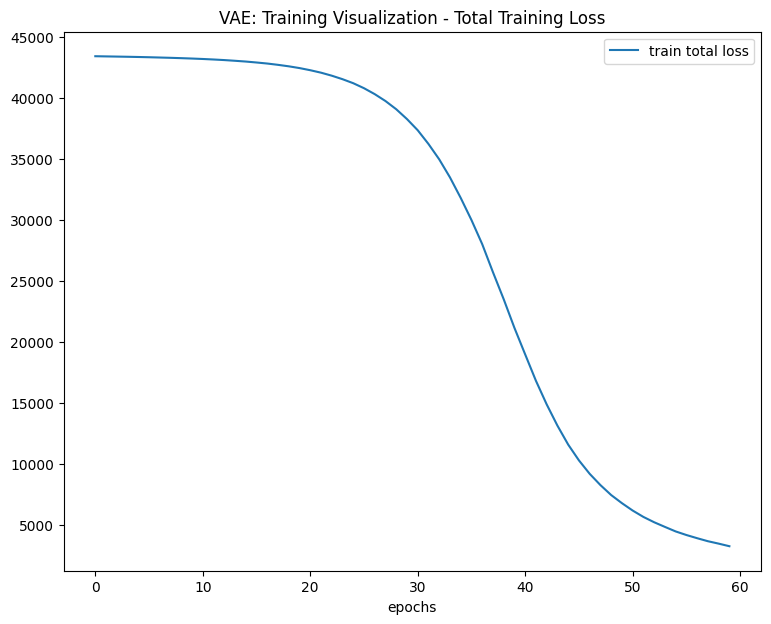

In [53]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

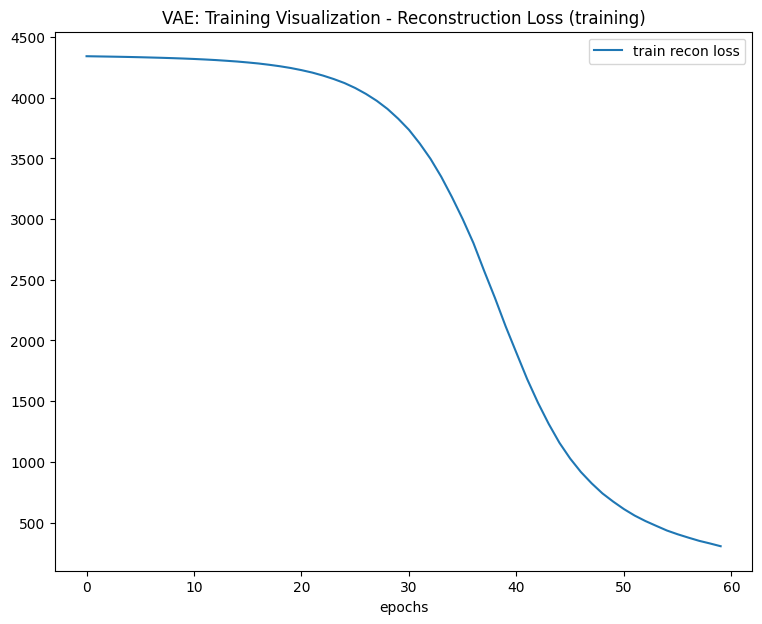

In [54]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

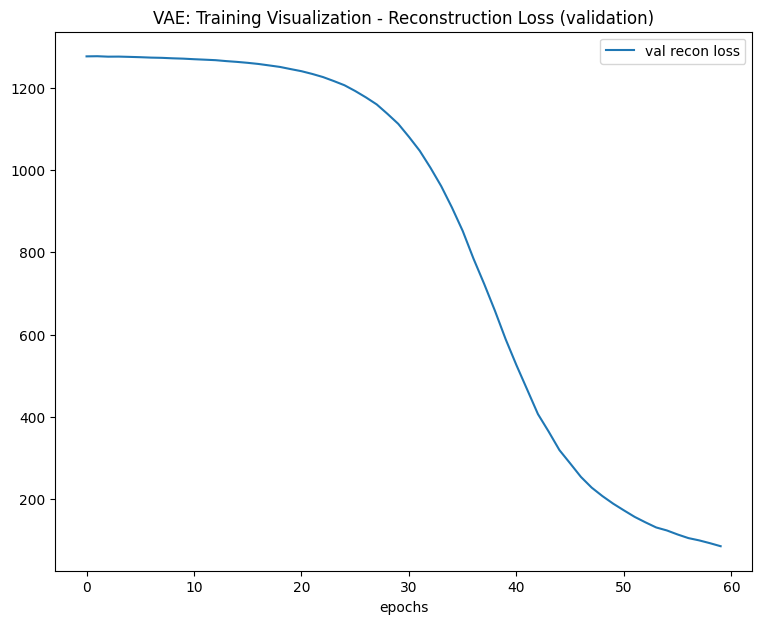

In [55]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['recon_loss'] for e in val_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

Visualise reconstructed images

In [56]:
# Get reconstructions, mean & log-variance from trained model-
X_train_reconstruced, mu, log_var = model(X_train[:1000, :])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


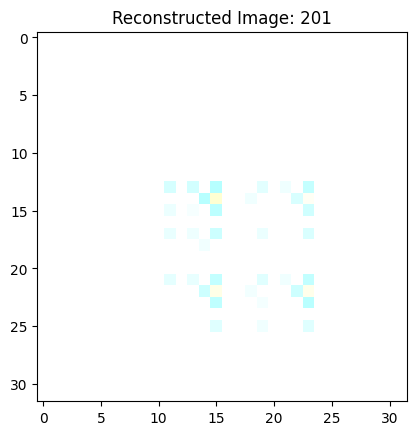

In [57]:
# Visualize one of reconstructed images-
img_idx = 200

plt.imshow(X_train_reconstruced[img_idx]*255) # *255 added
plt.title(f"Reconstructed Image: {img_idx + 1}")
plt.show()

In [58]:
# Sanity check-
X_train[:1000, :].shape, X_train_reconstruced.shape

((1000, 32, 32, 3), TensorShape([1000, 32, 32, 3]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

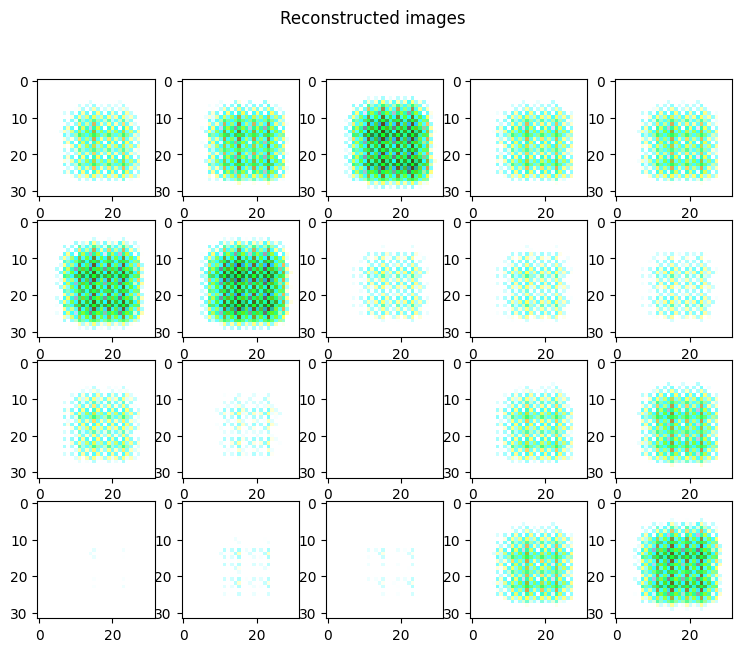

In [59]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i]*255) # *255 added

plt.suptitle("Reconstructed images")
plt.savefig('VAE_Reconstructed_Images2.png')
plt.show()